# Relax Inc. Challenge

Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user adoption .

In [117]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

sns.set()
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2019-04-23T21:37:23

CPython 2.7.15
IPython 5.8.0

compiler   : MSC v.1500 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


Import Data

In [153]:
users_df = pd.read_csv('takehome_users.csv',
                       parse_dates=['creation_time'])

user_engagement_df = pd.read_csv('takehome_user_engagement.csv',
                                 parse_dates=['time_stamp'])

Let's take a look at the data

In [154]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [155]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


The last session times are problematic to convert, since there are some NaN values

In [157]:
users_df.loc[0, 'last_session_creation_time']

1398138810.0

In [159]:
datetime.utcfromtimestamp(users_df.loc[0, 'last_session_creation_time']).strftime('%Y-%m-%d %H:%M:%S')

'2014-04-22 03:53:30'

Creation source is a good candidate for a dummy var

In [73]:
users_df['creation_source'].unique()

array(['GUEST_INVITE', 'ORG_INVITE', 'SIGNUP', 'PERSONAL_PROJECTS',
       'SIGNUP_GOOGLE_AUTH'], dtype=object)

In [76]:
len(users_df[(users_df['creation_source'] == 'GUEST_INVITE') | (users_df['creation_source'] == 'ORG_INVITE')])

6417

In [72]:
users_df['org_id'].unique()

array([ 11,   1,  94, 193, 197,  37,  74, 302, 318,  69, 130, 254,   0,
       175, 211,   2,  58,  54,   7,   6, 123,  81,  56, 134,  92, 251,
       283,  98, 401,  33,  59, 109, 276, 208, 332,  64, 235,  63,  14,
         4, 127,  32, 224, 304,  61,  51, 229,  88, 325, 150, 347, 203,
        21, 409, 215, 141,   5, 107, 184, 310, 367, 389,  89, 242,  68,
        16,  49, 185,  91, 172,   8,  43, 249,  26, 139,  70,  10, 252,
        53, 119,   3, 196, 335, 375, 303, 307,  25, 370,  83,  27, 306,
       118, 295,  19, 301, 100, 112, 263,  39,  12,  86, 402,  42, 103,
       373, 268,  30, 406,  48, 313,   9, 138, 261,  35, 264,  95,  55,
        60, 234,  28, 410, 170, 374,  15,  17, 364,  62, 244, 342, 225,
       121, 255, 411, 217, 165, 415, 104, 329, 278, 116, 151, 290, 200,
       187, 122, 353, 135, 328,  36,  13, 341, 349, 198, 153, 108,  77,
       142, 275, 176,  87, 191, 102, 245, 154, 218, 385,  76, 321, 159,
       371,  50,  75, 333, 137, 292, 286, 131, 178, 213, 376, 36

In [66]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [67]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


The point of this column is to sum it, since there are only 1s in it.

In [68]:
user_engagement_df.visited.unique()

array([1], dtype=int64)

### Data Cleaning

Fix last session timestamps.

The first try didn't work. All dates are in 1970

In [69]:
#users_df.loc[:, 'last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [161]:
users_df.loc[users_df['last_session_creation_time'].notna(), 'last_session_creation_time'] = \
    [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in users_df.loc[users_df['last_session_creation_time'].notna(),
                                                                                        'last_session_creation_time']]

In [166]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'])

In [167]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0


In [168]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 937.6+ KB


### Adopted User

Need a loop to assign a boolean to a new adopted user column for users_df.

This needs to go through the engagement df and see if the user has logged into the product on 3 separate days in at least one seven-day period.

#### Invited Users

Go through and make a column that is a boolean for whether or not the user joined via guest invite

Actually, that is covered by the creation_source values of GUEST_INVITE and ORG_INVITE

Practice for the final loop

In [95]:
user_engagement_df[user_engagement_df['user_id'] == 2].sort_values('time_stamp')

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1
6,2014-01-08 03:45:04,2,1
7,2014-02-03 03:45:04,2,1
8,2014-02-08 03:45:04,2,1
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1


In [82]:
timedelta(weeks=1)

datetime.timedelta(7)

Changing <= and >= to < and > will alter the results for this entry. That is a strange edge case.

In [94]:
user_2 = user_engagement_df[user_engagement_df['user_id'] == 2].sort_values('time_stamp')
user_2[(user_2['time_stamp'] - user_2.loc[9, 'time_stamp'] <= timedelta(weeks=1)) &
       (user_2['time_stamp'] >= user_2.loc[9, 'time_stamp'])]#['visited'].sum()

,time_stamp,user_id,visited
9,2014-02-09 03:45:04,2,1
10,2014-02-13 03:45:04,2,1
11,2014-02-16 03:45:04,2,1


In [98]:
def get_adoption_values(users_df, engagement_df):
    """
    
    """
    a_week = timedelta(weeks=1)
    
    
    for user in users_df['object_id']:  
        # Get the data for this user
        user_df = engagement_df[engagement_df['user_id'] == user].sort_values('time_stamp')
        
        # Assume a user isn't adopted until we find proof
        users_df.loc[users_df['object_id'] == user, 'adopted'] = 0
        
        # Look forward in time to find if there are 3 
        for dt in user_df['time_stamp']:
            # Find how many visits the user had between this one and a week from then
            weekly_visits = user_df[(user_df['time_stamp'] - dt <= a_week) &
                                    (user_df['time_stamp'] >= dt)]['visited'].sum()
            
            if (weekly_visits >= 3):
                users_df.loc[users_df['object_id'] == user, 'adopted'] = 1
                continue
        
    return users_df

In [101]:
%%time
users_df = get_adoption_values(users_df, user_engagement_df)

Wall time: 12min 53s


### Exploratory Data Analysis

Let's see if any trends look different, plotting for adopted users and otherwise

In [132]:
def plot_bars(df, groupby_col, y_col, x_rot=0):
    """
    
    """
    if y_col:
        return df.groupby(groupby_col).sum()[y_col].plot.bar(rot=x_rot)
    else:
        return df.groupby(groupby_col).size().plot.bar(rot=x_rot)

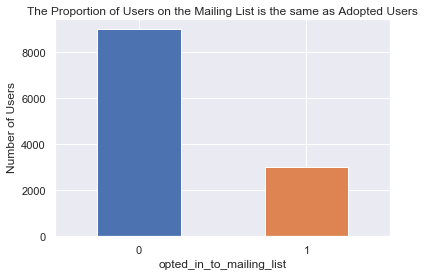

In [134]:
_ = plot_bars(users_df, 'opted_in_to_mailing_list', None)

_ = plt.ylabel('Number of Users')
_ = plt.title('The Proportion of Users on the Mailing List')

plt.show()

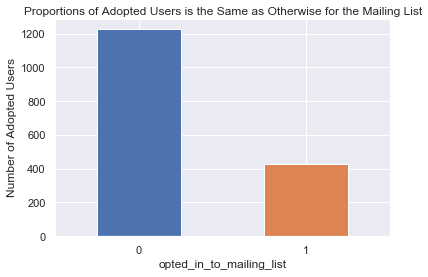

In [149]:
_ = plot_bars(users_df, 'opted_in_to_mailing_list', 'adopted')

_ = plt.ylabel('Number of Adopted Users')
_ = plt.title('Proportions of Adopted Users is the Same as Otherwise for the Mailing List')

plt.show()

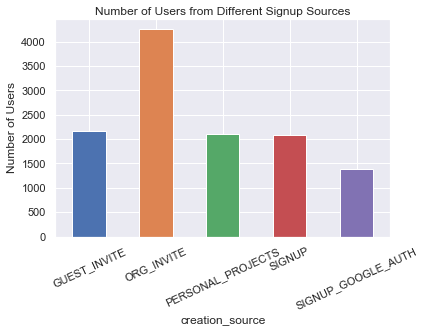

In [147]:
_ = plot_bars(users_df, 'creation_source', None, 25)

_ = plt.title('Number of Users from Different Signup Sources')
_ = plt.ylabel('Number of Users')

plt.show()

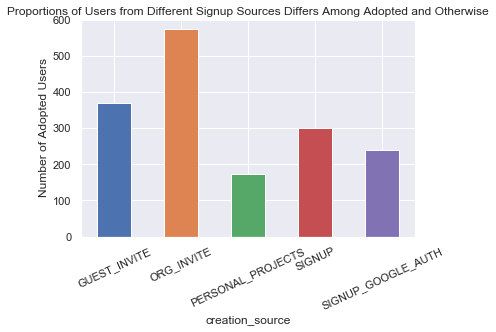

In [148]:
_ = plot_bars(users_df, 'creation_source', 'adopted', 25)

_ = plt.title('Proportions of Users from Different Signup Sources Differs Among Adopted and Otherwise')
_ = plt.ylabel('Number of Adopted Users')

plt.show()

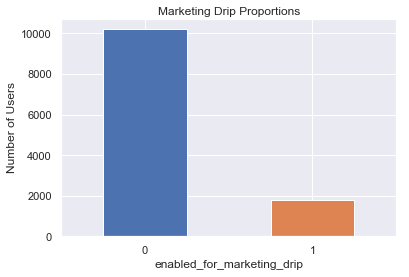

In [146]:
_ = plot_bars(users_df, 'enabled_for_marketing_drip', None)

_ = plt.title('Marketing Drip Proportions')
_ = plt.ylabel('Number of Users')

plt.show()

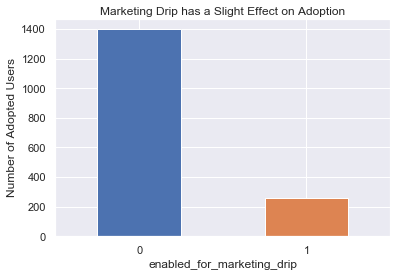

In [145]:
_ = plot_bars(users_df, 'enabled_for_marketing_drip', 'adopted')

_ = plt.title('Marketing Drip has a Slight Effect on Adoption')
_ = plt.ylabel('Number of Adopted Users')

plt.show()

### Logistic Regression

Predict which factors will be the most important for a user to be adopted

In [150]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.398138810,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1970-01-01 00:00:01.396237504,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1970-01-01 00:00:01.363734892,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.369210168,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1970-01-01 00:00:01.358849660,0,0,193,5240.0,0.0


In [151]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


#### Feature Engineering

Put a column for how many logins each user has

